In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

In [2]:
df_out = pd.read_pickle('df_out.pkl')
df_breeds = pd.read_pickle('df_breeds.pkl')
df_out_with_breeds_info = pd.read_pickle('df_out_with_breeks_info.pkl')
df_breeds_with_info = pd.read_pickle('df_breeds_with_info.pkl')
df_out.info()
df_out.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149511 entries, 0 to 149510
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Animal ID                 149511 non-null  string        
 1   Name                      106260 non-null  string        
 2   DateTime                  149511 non-null  datetime64[ns]
 3   MonthYear                 149511 non-null  string        
 4   Date of Birth             149511 non-null  datetime64[ns]
 5   Outcome Type              149485 non-null  string        
 6   Outcome Subtype           68443 non-null   string        
 7   Animal Type               149511 non-null  string        
 8   Sex upon Outcome          149509 non-null  string        
 9   Age upon Outcome          149465 non-null  string        
 10  Breed                     149511 non-null  string        
 11  Color                     149511 non-null  string        
 12  Co

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,...,Color 1 G,Color 1 B,Color 1 H,Color 1 S,Color 1 V,Age upon Outcome (years),Male,Female,NeuteredOrSpayed,Adopted
0,A794011,Chunk,2019-05-08 18:20:00,May 2019,2017-05-02,Rto-Adopt,<NA>,Cat,Neutered Male,2 years,...,1.0,1.0,0.0,0.0,1.0,2.0,True,False,True,True
1,A776359,Gizmo,2018-07-18 16:02:00,Jul 2018,2017-07-12,Adoption,<NA>,Dog,Neutered Male,1 year,...,0.44,0.09,0.119444,0.85,0.59,1.0,True,False,True,True
2,A821648,<NA>,2020-08-16 11:38:00,Aug 2020,2019-08-16,Euthanasia,<NA>,Other,Unknown,1 year,...,<NA>,<NA>,<NA>,<NA>,<NA>,1.0,False,False,False,False
3,A720371,Moose,2016-02-13 17:59:00,Feb 2016,2015-10-08,Adoption,<NA>,Dog,Neutered Male,4 months,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.333333,True,False,True,True
4,A674754,<NA>,2014-03-18 11:47:00,Mar 2014,2014-03-12,Transfer,Partner,Cat,Intact Male,6 days,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.016438,True,False,False,False


# NN

This section will attempt to look for correlations between the names of individual animals, the names and characteristics of their breeds, their ages, and whether or not they got adopted.

It uses a neural network with supervised learning to predict the value of "Adopted" given the other features.

To regress text against numeric values, the vector embedding of the string is used. These embeddings are computed beforehand to optimize training.

## Loading and experimenting with word embeddings

In [3]:
%pip install tensorflow
%pip install tensorflow_hub

# # NOTE: when I ran this, it said:
# # "Note: you may need to restart the kernel to use updated packages."

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# adapted from TensorFlow tutorial
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
# NOTE: this model is about 1 GB, and it sometimes downloads the model again even after it's
# already run and downloaded the model before

import tensorflow as tf
import tensorflow_hub as hub
import os
import re

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

2023-04-01 16:59:12.819604: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-01 16:59:16.418779: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-01 16:59:16.440053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 16:59:21.671574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


2023-04-01 16:59:41.537272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


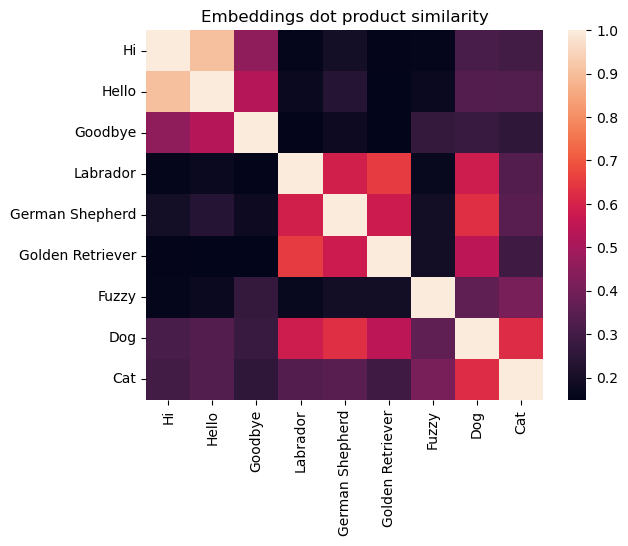

In [5]:
# from TensorFlow example

def similarity(messages):
    embeddngs = embed(messages)
    corr = np.inner(embeddngs, embeddngs)
    g = sns.heatmap(corr, xticklabels=messages, yticklabels=messages)
    g.set_xticklabels(messages, rotation=90)
    g.set_title('Embeddings dot product similarity')

similarity([
    'Hi', 'Hello', 'Goodbye',
    'Labrador', 'German Shepherd', 'Golden Retriever',
    'Fuzzy', 'Dog', 'Cat'
])

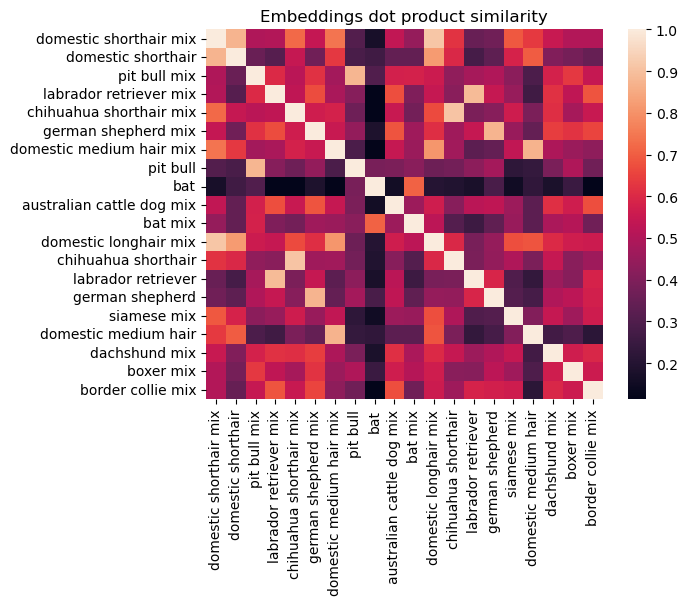

In [6]:
similarity(list(df_breeds.Breed.str.lower().head(20)))

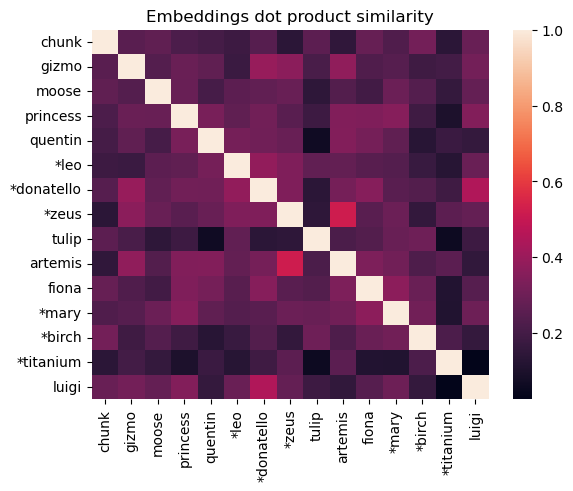

In [7]:
similarity(list(df_out.Name.str.lower().head(20).dropna()))

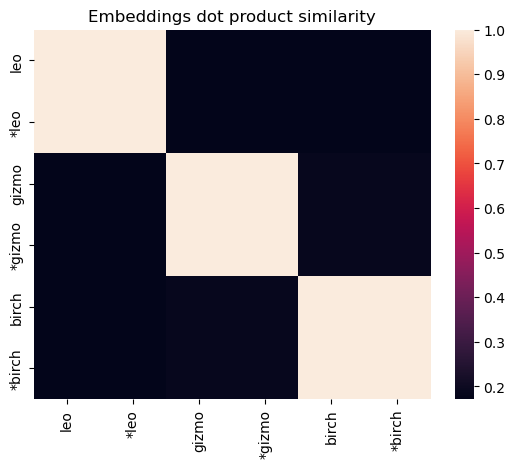

In [8]:
# this is good; it shows that the source dataset will regress similarly
# with or without the asterisk in front of some names

similarity([
    'leo', '*leo',
    'gizmo', '*gizmo',
    'birch', '*birch',
])

## Regressing features to adoption

In [9]:
from math import floor

columns_remove_groups = [
    # group 1
    [
        'Animal ID',
        'MonthYear',
        'DateTime',
        'Date of Birth',
        
        'Outcome Type',
        'Outcome Subtype',
        'Sex upon Outcome',
        'Age upon Outcome', # the numeric column "Age upon Outcome (years)" is still kept
        'BreedsInfoName',
        'Breed (catalog)'
    ],
    
    # group 2
    [
        'Color 0',
        'Color 1'
    ],
    
    # group 3
    [
        'Breed Group AKC',
        'Breed Group CKC',
        'Breed Group UKC',
        'CKC Subgroup'
    ],
]

columns_remove = columns_remove_groups[0] + columns_remove_groups[1]

def convert_series_to_tensor(series):
    if series.dtype == 'string':
        return embed(input=list(series))
    else:
        t = tf.cast(tf.convert_to_tensor(series.astype(dtype=float)), tf.float32)
        return tf.reshape(t, t.shape + [1])

def convert_df_tf(df):
    tensors = [convert_series_to_tensor(df[column]) for column in df.columns]
    return tf.concat(tensors, axis=1)

def network_data(df):
    df = df.drop(columns=columns_remove)
    df = df.dropna()
    
    X = df
    y = X.pop('Adopted')
    
    X_t = convert_df_tf(X)
    y_t = convert_series_to_tensor(y)

    return (X_t, y_t)

def split_df(df, ratio=0.8):
    df = df.sample(frac=1,random_state=1).reset_index()
    size_1 = floor(df.shape[0] * ratio)
    return (df.head(size_1), df.tail(df.shape[0] - size_1))

# data_size = 50000
data_size = 100000
(df_train, df_test) = split_df(df_out_with_breeds_info.head(data_size))

(X_train, y_train) = network_data(df_train)
(X_test, y_test) = network_data(df_test)

2023-04-01 16:59:46.448616: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 332108800 exceeds 10% of free system memory.
2023-04-01 16:59:48.017313: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 278656000 exceeds 10% of free system memory.
2023-04-01 16:59:48.878726: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 497559040 exceeds 10% of free system memory.
2023-04-01 16:59:49.815487: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 246758400 exceeds 10% of free system memory.
2023-04-01 16:59:50.783693: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369909760 exceeds 10% of free system memory.


## Multilayer perceptron

In [10]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='linear'),
    
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear'),
    
    tf.keras.layers.Dense(8, activation='linear'),
    
    tf.keras.layers.Dense(1)
])

model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [11]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='linear'),
    
    # tf.keras.layers.Dense(32, activation='linear'),
    # tf.keras.layers.Dense(32, activation='linear'),
    # tf.keras.layers.Dense(32, activation='linear'),
    # tf.keras.layers.Dense(32, activation='linear'),
    
    tf.keras.layers.Dense(8, activation='linear'),
    
    tf.keras.layers.Dense(1)
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [12]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='linear'),
    
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear'),
    
    tf.keras.layers.Dense(8, activation='linear'),
    
    tf.keras.layers.Dense(1)
])

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='linear'),
    
    # tf.keras.layers.Dense(32, activation='linear'),
    # tf.keras.layers.Dense(32, activation='linear'),
    # tf.keras.layers.Dense(32, activation='linear'),
    # tf.keras.layers.Dense(32, activation='linear'),
    
    tf.keras.layers.Dense(8, activation='linear'),
    
    tf.keras.layers.Dense(1)
])

model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='linear'),
    
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear'),
    
    tf.keras.layers.Dense(8, activation='linear'),
    
    tf.keras.layers.Dense(1)
])

model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.losses.MeanSquaredError(),
    metrics=['accuracy']
)

In [23]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='linear'),
    
    # tf.keras.layers.Dense(32, activation='linear'),
    # tf.keras.layers.Dense(32, activation='linear'),
    # tf.keras.layers.Dense(32, activation='linear'),
    # tf.keras.layers.Dense(32, activation='linear'),
    
    tf.keras.layers.Dense(8, activation='linear'),
    
    tf.keras.layers.Dense(1)
])

model6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.losses.MeanSquaredError(),
    metrics=['accuracy']
)

In [24]:
models = [model1, model2, model3, model4, model5, model6]

In [25]:
for model in models:
    model.fit(X_train, y_train, epochs=10)

Epoch 1/10
942/942 [==============================] - 7s 8ms/step - loss: 0.7607 - accuracy: 0.5583
Epoch 2/10
942/942 [==============================] - 7s 7ms/step - loss: 0.7402 - accuracy: 0.5596
Epoch 3/10
942/942 [==============================] - 7s 7ms/step - loss: 5.4432 - accuracy: 0.5513
Epoch 4/10
942/942 [==============================] - 7s 7ms/step - loss: 0.7846 - accuracy: 0.5609
Epoch 5/10
942/942 [==============================] - 7s 7ms/step - loss: 0.6689 - accuracy: 0.5621
Epoch 6/10
942/942 [==============================] - 7s 7ms/step - loss: 0.9381 - accuracy: 0.5523
Epoch 7/10
942/942 [==============================] - 7s 7ms/step - loss: 0.6708 - accuracy: 0.5552
Epoch 8/10
942/942 [==============================] - 7s 7ms/step - loss: 0.6884 - accuracy: 0.5485
Epoch 9/10
942/942 [==============================] - 7s 7ms/step - loss: 0.7081 - accuracy: 0.5442
Epoch 10/10
942/942 [==============================] - 7s 7ms/step - loss: 860.8011 - accuracy: 0.53

In [26]:
for model in models:
    model.evaluate(X_test, y_test)

237/237 [==============================] - 0s 2ms/step - loss: 0.9700 - accuracy: 0.5503


### Analysis

| Model | Loss function | Accuracy |
|---|---|---|
| 1 | BinaryCrossentropy(from_logits=True) | 0.6200 |
| 2 | BinaryCrossentropy(from_logits=True) | 0.5354 |
| 3 | BinaryCrossentropy(from_logits=False) | 0.5409 |
| 4 | BinaryCrossentropy(from_logits=False) | 0.4591 |
| 5 | MeanSquaredError() | 0.4679 |
| 6 | MeanSquaredError() | 0.5503 |

Model 1 seems to perform slightly above 50%, but this could be an outlier. Different models should be experimented with to determine if the animal's name, breed, color, age, sex, and other characteristics can predict whether or not it will be adopted.
